# Ensemble Light Curves

Since all `spotter` functions are [JAX](https://jax.readthedocs.io/en/latest/) functions, we can easily `jax.vmap` them to create ensemble of light curves. 

Let's first define some stellar parameters

In [1]:
from spotter.core import vec
import numpy as np

N = 2**4  # number of sides
u = (0.4, 0.1)  # limb darkening coefficient
X = vec(N)  # pixels coordinates

# number of samples
samples = 50
# uniformly drawn inclinations of the stars
incs = np.random.uniform(-np.pi, np.pi, samples)

As in the [Gaussian Process tutorial](./surface_gp.ipynb), we define a GP to draw active surfaces

In [2]:
import tinygp
from spotter.kernels import GreatCircleDistance

kernel = 0.1 * tinygp.kernels.Matern52(0.4, distance=GreatCircleDistance())
gp = tinygp.GaussianProcess(kernel, X)

This time, we will draw multiple samples from the GP

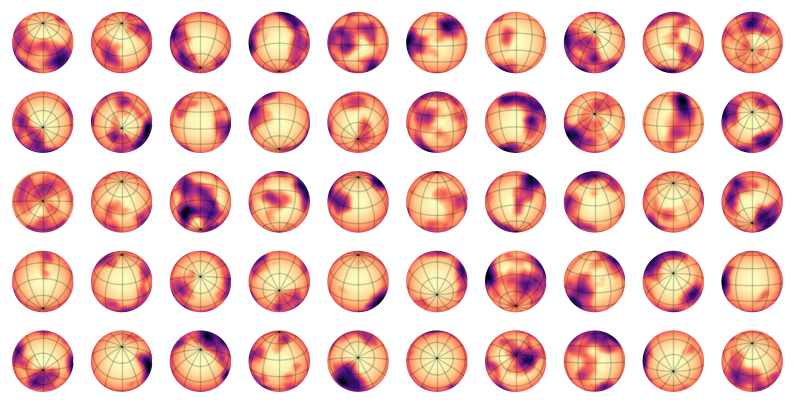

In [3]:
import jax
import matplotlib.pyplot as plt
from spotter.viz import show

y = gp.sample(jax.random.PRNGKey(4), shape=(samples,))
y = 1.0 - y.clip(0.0, 1.0)

fig, ax = plt.subplots(5, 10, figsize=(10, 5))
ax = ax.flatten()
for i in range(len(y)):
    show(y[i], ax=ax[i], inc=incs[i], u=u)

We can now use all these surfaces in a `jax.vmap` version of the `flux` function 

In [4]:
from spotter.core import flux

phases = np.linspace(0, 2 * np.pi, 100)

# the jax.vmap function!
fluxes_function = jax.vmap(
    jax.vmap(flux, in_axes=(0, 0, None, None)), in_axes=(None, None, None, 0)
)

fluxes = fluxes_function(y, incs, u, phases)

and plot the resulting light curves

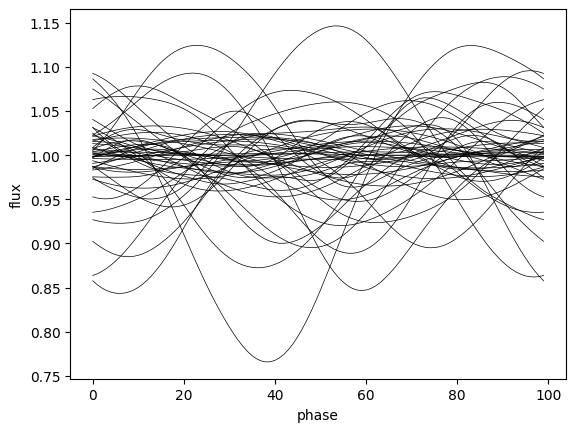

In [5]:
plt.plot(fluxes / np.median(fluxes, 0)[None, :], c="k", lw=0.5)
plt.xlabel("phase")
_ = plt.ylabel("flux")

Let's draw a larger sample and this time compute the amplitude distributions of the light curves.

In [6]:
import healpy as hp
import jax.numpy as jnp

resolution = hp.nside2resol(N)
hp_resolution = resolution * 3
phases = jnp.arange(0, 2 * jnp.pi, hp_resolution)

In [7]:
n = 1000
incs = np.random.uniform(-np.pi, np.pi, n)
y = gp.sample(jax.random.PRNGKey(5), shape=(n,))
y = 1.0 - y.clip(0.0, 1.0)

In [8]:
def amplitudes(y, inclinations, u, phases):
    fluxes = fluxes_function(y, inclinations, u, phases)
    return jnp.ptp(fluxes, axis=0)


amps = jax.jit(amplitudes)(y, incs, u, phases)

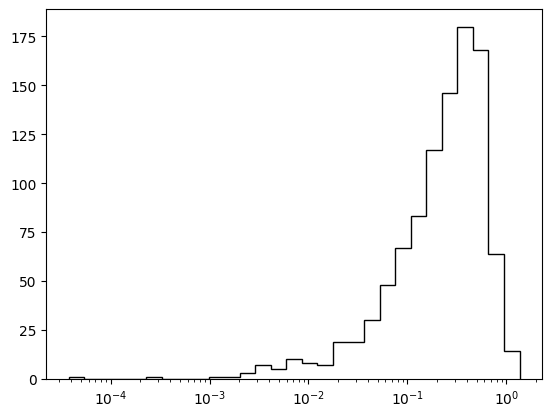

In [10]:
# log bins
bins = np.logspace(np.log10(amps.min()), np.log10(amps.max()), 30)
_ = plt.hist(amps, bins=bins, histtype="step", color="k")
plt.xscale("log")